In [2]:
import import_files as MrtRecommendationDependencies
from ridership_transformer import RidershipTransformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import database
from database import TrainUpdate
from datetime import datetime
import numpy as np

In [3]:
#Train-Test Split Module
from sklearn.model_selection import train_test_split

#Linear Regression Algorithm from sklearn
from sklearn import linear_model

#Metrics to measure model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#Standard Scaler for Standardization
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

In [19]:
ridership_df = pd.read_csv(MrtRecommendationDependencies.get_dataset_path("cubao_transformed.csv"), parse_dates=['datetime'])#, index_col="datetime")
weather_df = pd.read_csv(MrtRecommendationDependencies.get_dataset_path("weather_filtered.csv"), parse_dates=['datetime'])#, index_col="datetime")

In [28]:
print(weather_df.info())
print(ridership_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9273 entries, 0 to 9272
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      9273 non-null   datetime64[ns]
 1   temp          9273 non-null   float64       
 2   humidity      9273 non-null   int64         
 3   rain_1h       995 non-null    float64       
 4   rain_3h       1014 non-null   float64       
 5   weather_main  9273 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 434.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7303 entries, 0 to 7302
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  7303 non-null   datetime64[ns]
 1   entry     7303 non-null   int64         
 2   exit      7303 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 171.3 KB
None


In [31]:
new_df = ridership_df.merge(weather_df, how="right", left_on='datetime', right_on='datetime')

In [32]:
query = TrainUpdate.filter(TrainUpdate.datetime != None)

In [33]:
train_updates = pd.read_sql(query.statement, query.session.bind)
# train_updates.set_index("datetime", inplace=True)

In [34]:
df = new_df.merge(train_updates, left_on='datetime', right_on='datetime').fillna(0)

In [46]:
test_df = df.iloc[0:140]

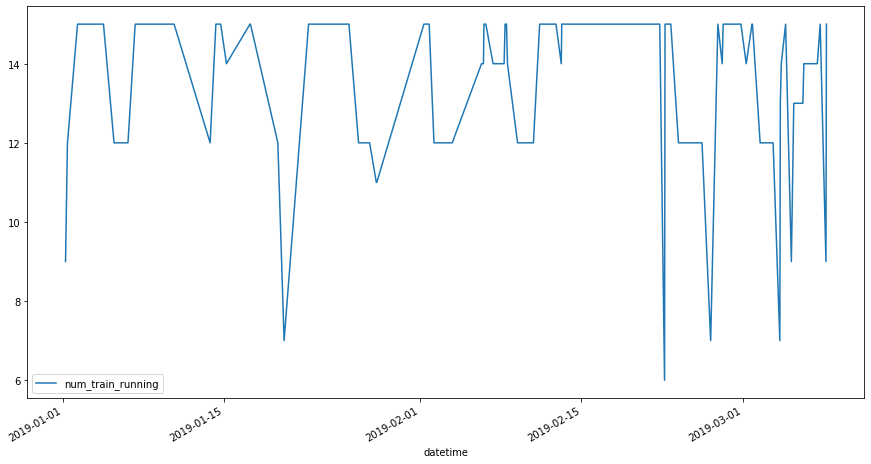

In [47]:

time_series_num_train = test_df.drop(test_df.columns.difference(['datetime','num_train_running']), axis=1)
time_series_num_train.set_index("datetime",inplace=True)
# time_series_num_train.head(40)
time_series_num_train.plot(figsize=(15,8))




In [60]:
ridership_df = pd.read_csv(MrtRecommendationDependencies.get_dataset_path("cubao_transformed.csv"), parse_dates=['datetime'], index_col="datetime")
weather_df = pd.read_csv(MrtRecommendationDependencies.get_dataset_path("weather_filtered.csv"), parse_dates=['datetime'], index_col="datetime")
train_updates = pd.read_sql(query.statement, query.session.bind)
train_updates.set_index("datetime", inplace=True)
df = ridership_df.join(weather_df, how="right")
df = df.join(train_updates, how="left").fillna(0)

In [52]:
df[df.headway > 0]

,entry,exit,temp,humidity,rain_1h,rain_3h,weather_main,tweet_id,num_train_running,num_train_operational,num_dalian_train_running,num_dalian_train_operational,headway
datetime,,,,,,,,,,,,,
2018-07-01 19:00:00,1865.0,3379.0,26.41,87,NaN,NaN,Haze,1.0,12.0,13.0,NaN,None,8.5
2018-07-02 05:00:00,1254.0,108.0,31.29,60,NaN,NaN,Haze,2.0,8.0,8.0,NaN,None,8.0
2018-07-02 18:00:00,2180.0,3415.0,27.23,84,NaN,NaN,Haze,4.0,15.0,15.0,NaN,None,7.0
2018-07-03 05:00:00,1255.0,172.0,30.09,66,NaN,NaN,Haze,3.0,7.0,7.0,NaN,None,8.0
2018-07-03 20:00:00,1502.0,2471.0,26.11,87,NaN,NaN,Haze,6.0,14.0,14.0,NaN,None,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-29 19:00:00,2222.0,4156.0,26.32,88,NaN,NaN,Haze,1782.0,12.0,12.0,NaN,None,8.5
2019-06-30 06:00:00,590.0,444.0,30.94,70,NaN,NaN,Haze,1790.0,12.0,12.0,NaN,None,8.5
2019-06-30 16:00:00,1522.0,2052.0,26.91,86,NaN,1.7,Rain,1809.0,12.0,13.0,NaN,None,8.5


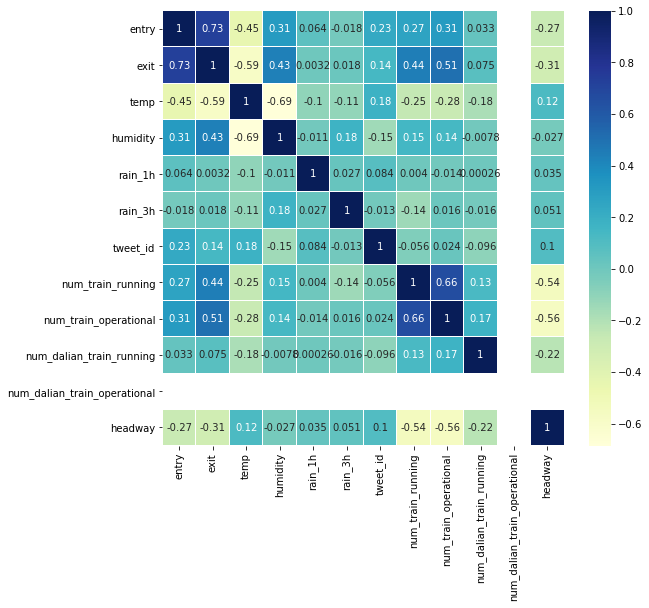

In [54]:
corrmat = df[df.headway > 0].corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1,annot=True) 

In [61]:
test_df = df.drop(df.columns.difference(['entry', 'exit','headway', 'weather_main', 'num_train_running']), axis=1)

In [62]:
test_df = test_df[test_df.headway > 0]

In [63]:
test_df.head()

,entry,exit,weather_main,num_train_running,headway
datetime,,,,,
2018-07-01 19:00:00,1865.0,3379.0,Haze,12.0,8.5
2018-07-02 05:00:00,1254.0,108.0,Haze,8.0,8.0
2018-07-02 18:00:00,2180.0,3415.0,Haze,15.0,7.0
2018-07-03 05:00:00,1255.0,172.0,Haze,7.0,8.0
2018-07-03 20:00:00,1502.0,2471.0,Haze,14.0,7.5


In [64]:
weather_df = pd.get_dummies(test_df, columns=["weather_main"])

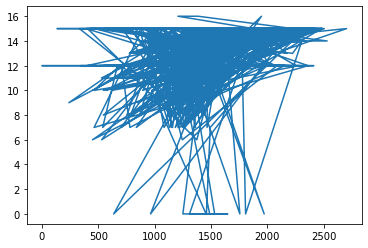

In [65]:
plt.plot(weather_df['entry'], weather_df['num_train_running'])

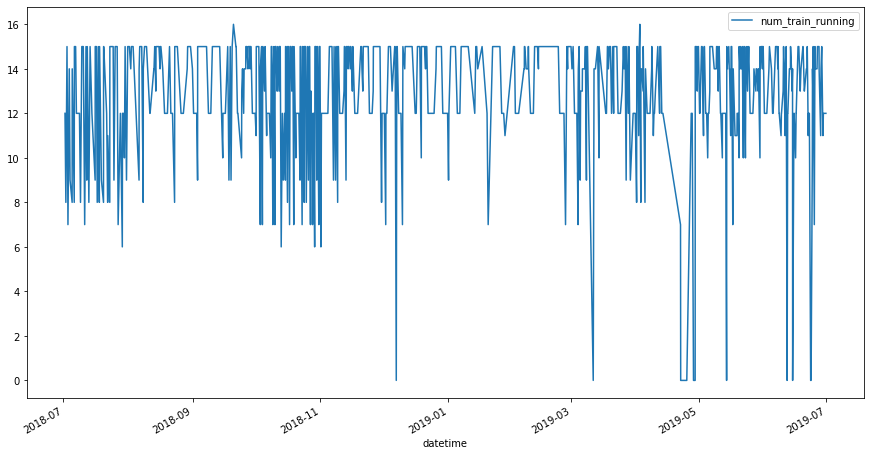

In [85]:
line_plot_data = weather_df.reset_index()[['datetime', 'num_train_running']].set_index('datetime')
line_plot_data.plot(figsize=(15,8))

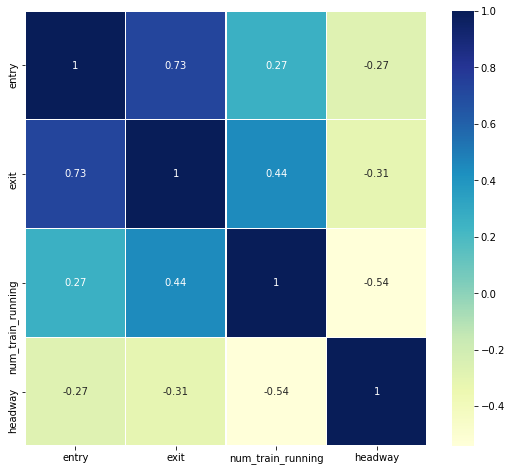

In [66]:
corrmat = weather_df[['entry', 'exit', 'num_train_running', 'headway']].corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1,annot=True) 

In [67]:
train, test = train_test_split(weather_df,test_size=0.30, random_state=123)

In [68]:
train.reset_index(drop=True, inplace=True)

In [69]:
test.reset_index(drop=True, inplace=True)

In [70]:
train.head()

,entry,exit,num_train_running,headway,weather_main_Clouds,weather_main_Haze,weather_main_Rain,weather_main_Smoke,weather_main_Thunderstorm
0,726.0,888.0,12.0,8.5,0,0,0,0,1
1,2219.0,3501.0,15.0,7.0,0,1,0,0,0
2,1139.0,1599.0,15.0,7.0,0,1,0,0,0
3,1289.0,1681.0,15.0,7.0,0,1,0,0,0
4,1320.0,2679.0,15.0,7.0,0,1,0,0,0


In [71]:
# x_train = train.drop('headway', axis=1)
x_train = train.drop(['headway', 'num_train_running'], axis=1)
y_train = train['num_train_running']

In [72]:
# x_test = test.drop('headway', axis=1)
x_test = test.drop(['headway', 'num_train_running'], axis=1)
y_test = test['num_train_running']

In [73]:
scaler = Normalizer()

scaled_x_train = scaler.fit_transform(x_train)

In [74]:
linreg = linear_model.LinearRegression()

In [75]:
linreg.fit(scaled_x_train, y_train)

LinearRegression()

In [76]:
scaled_x_test = scaler.transform(x_test)

In [77]:
y_pred = linreg.predict(scaled_x_test)

In [78]:
#Measure the performance of the model
r2 = r2_score(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(("r2: %.2f") %r2)
print(("mae: %.2f") %mae)
print(("mse: %.2f") %mse)
print(("rmse: %.2f") %rmse)

r2: 22.05
mae: 1.52
mse: 5.18
rmse: 2.28


In [79]:
print(y_test[4])
print(y_pred[4])

15.0
13.610660569621109


Text(0.5, 1.0, 'Actual Sales vs Predicted Sales')

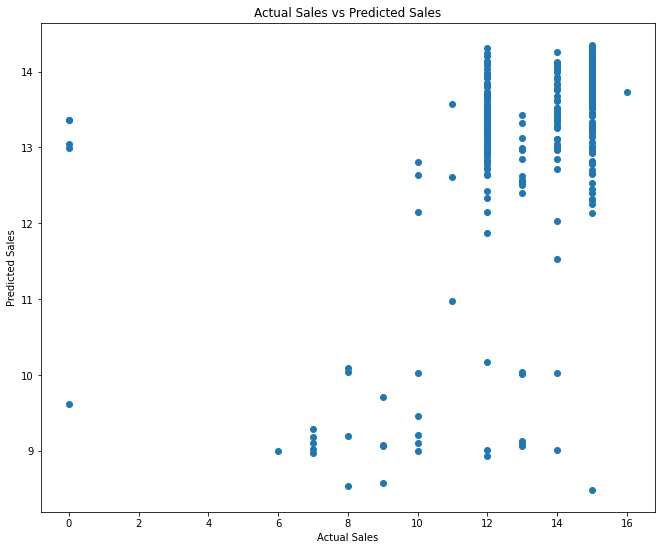

In [80]:
#Visualize the results

#Figure Size
f, ax = plt.subplots(figsize=(11, 9))

#Function for Scatter Plot
plt.scatter(y_test, y_pred)

#Labels
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual Sales vs Predicted Sales")

In [81]:
x_test.head()

,entry,exit,weather_main_Clouds,weather_main_Haze,weather_main_Rain,weather_main_Smoke,weather_main_Thunderstorm
0,702.0,1698.0,1,0,0,0,0
1,1330.0,3163.0,1,0,0,0,0
2,1324.0,1863.0,0,1,0,0,0
3,1220.0,1792.0,0,1,0,0,0
4,1443.0,1723.0,0,1,0,0,0
